In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine as ce
from sqlalchemy import inspect
from pathlib import Path
import re
import contractions

# Part 0: Loading the files

In [2]:
DATA = Path("books.db")

In [3]:
engine = ce("sqlite:///"+str(DATA))

In [4]:
inspector = inspect(engine)

In [5]:
print(inspector.get_table_names())

['authors', 'book_file', 'book_original', 'books', 'text_files']


In [6]:
books_df = pd.read_sql("books", con = engine)
author_df = pd.read_sql("authors", con = engine)
book_file_df = pd.read_sql("book_file", con = engine)
text_file_df = pd.read_sql("text_files", con = engine)

# Part 1: Convert book files into sentences

In [7]:
# Convert the book text into lowercase
filtered_text = pd.DataFrame()
filtered_text['text'] = text_file_df['text'].apply(lambda x: list(filter(None, x.lower().split("\n"))))

In [8]:
gender_lst = ['woman', 'women', 'female', 'she', 'her', 'hers', 'man', 'men', 'male', 'he', 'his', 'him']
woman_lst = ['woman', 'women', 'female', 'she', 'her', 'hers']
man_lst = ['man', 'men', 'male', 'he', 'his', 'him']

In [9]:
# Filter out the sentences that contain gender words
filtered_text['text'] = filtered_text['text'].apply(lambda x: [sentence for sentence in x if any(word in sentence.split() for word in gender_lst)])

In [10]:
sentence_count = 0
for index, row in filtered_text.iterrows():
    sentence_count += len(row['text'])

In [11]:
sentence_count

2005472

In [12]:
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tommy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tommy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
wnl = WordNetLemmatizer()

In [15]:
home_category = ['home', 'homes', 'domestic', 'household', 'households', 'chore', 'chores', 'family', 'families']
work_category = ['work', 'works', 'worked', 'labor', 'worker', 'workers', 'economy', 'trade', 'trades', \
                 'business', 'businesses', 'job', 'jobs', 'company', 'companies', 'industry', 'industries', \
                 'pay', 'pays', 'paid', 'working', 'salary', 'salaries', 'wage', 'wages']
achievement_category = ['power', 'authority', 'authorities', 'achievement', 'control', 'controls', 'controlled',\
                        'won', 'win', 'wins', 'powerful', 'success', 'succeed', 'succeeded', 'successful',\
                        'better', 'effort', 'efforts', 'plan', 'plans', 'planned', 'try', 'tries', 'tried', 'leader']

In [16]:
filtered_text['text'] = filtered_text['text'].apply(lambda x: [sentence for sentence in x \
    if any(word in sentence.split() for word in home_category)\
    or any(word in sentence.split() for word in work_category)\
    or any(word in sentence.split() for word in achievement_category)])

In [17]:
sentence_count = 0
for index, row in filtered_text.iterrows():
    sentence_count += len(row['text'])

In [18]:
sentence_count

67701

In [19]:
sentences_df = pd.DataFrame(columns = ['text', 'gender', 'category'])

In [20]:
# Building the sentences with labels
for index, row in filtered_text.iterrows():
    for i in range(len(row['text'])):
        if any(word in row['text'][i].split() for word in woman_lst) and any(
                word in row['text'][i].split() for word in man_lst):
            break

        elif any(word in row['text'][i].split() for word in woman_lst):
            wordlist = [x for x in row['text'][i].split() if x in woman_lst]
            for target_word in wordlist:
                row['text'][i] = re.sub(r"\b%s\b" % target_word, 'woman', row['text'][i])
            curr_categories = []
            if any(word in row['text'][i].split() for word in home_category):
                curr_categories.append('home')

            if any(word in row['text'][i].split() for word in work_category):
                curr_categories.append('work')

            if any(word in row['text'][i].split() for word in achievement_category):
                curr_categories.append('achievement')

            sentences_df = sentences_df.append({'text': row['text'][i], 'gender': 'woman', 'category': curr_categories},
                                               ignore_index=True)

        elif any(word in row['text'][i].split() for word in man_lst):
            wordlist = [x for x in row['text'][i].split() if x in man_lst]
            for target_word in wordlist:
                row['text'][i] = re.sub(r"\b%s\b" % target_word, 'man', row['text'][i])
            curr_categories = []
            if any(word in row['text'][i].split() for word in home_category):
                curr_categories.append('home')

            if any(word in row['text'][i].split() for word in work_category):
                curr_categories.append('work')

            if any(word in row['text'][i].split() for word in achievement_category):
                curr_categories.append('achievement')
                
            sentences_df = sentences_df.append({'text': row['text'][i], 'gender': 'man', 'category': curr_categories},
                                               ignore_index=True)

In [21]:
sentences_df.head(10)

,text,gender,category
0,till with that wealth man pays man soldiery.,man,[work]
1,"better to die than leave man banneret.""",man,[achievement]
2,"yet which might win they knew not, in man thou...",man,[achievement]
3,"then find man men, man company are worth.""",man,[work]
4,"at the sword's point man yet shall pay our meed.""",man,[work]
5,no man on earth has more nor better found.,man,[achievement]
6,better man loves murder and treachery,man,[achievement]
7,"soon as rollant man senses won and knew,",man,[achievement]
8,"i won for man with thee anjou, bretaigne,",man,[achievement]
9,"and won for man with thee peitou, the maine,",man,[achievement]


# Part 2: Preprocessing and Cleaning

In [22]:
lemmatizer = WordNetLemmatizer()

In [23]:
sentences_df['text'] = sentences_df['text'].replace(r'[^A-Za-z0-9 \']+', '', regex=True)
sentences_df['text'] = sentences_df['text'].replace(r'  ', ' ', regex=True)

for index, content in enumerate(sentences_df['text']):
    if '\'' not in content:
        continue
    sentences_df.replace(content, contractions.fix(content), inplace=True)

In [24]:
sentences_df.head(10)

,text,gender,category
0,till with that wealth man pays man soldiery,man,[work]
1,better to die than leave man banneret,man,[achievement]
2,yet which might win they knew not in man thought,man,[achievement]
3,then find man men man company are worth,man,[work]
4,at the sword's point man yet shall pay our meed,man,[work]
5,no man on earth has more nor better found,man,[achievement]
6,better man loves murder and treachery,man,[achievement]
7,soon as rollant man senses won and knew,man,[achievement]
8,i won for man with thee anjou bretaigne,man,[achievement]
9,and won for man with thee peitou the maine,man,[achievement]


In [25]:
space = ' '
stop_words = set(stopwords.words('english'))
for index, content in enumerate(sentences_df['text']):
    filtered = []
    word_tokens = word_tokenize(content)
    for w in word_tokens:
        if w not in stop_words:
            # perform lemmatization
            final_w = lemmatizer.lemmatize(w)
            filtered.append(final_w)
    filtered_join = space.join(filtered)
    sentences_df.at[index, 'text'] = filtered_join

In [26]:
sentences_df.head(10)

,text,gender,category
0,till wealth man pay man soldiery,man,[work]
1,better die leave man banneret,man,[achievement]
2,yet might win knew man thought,man,[achievement]
3,find man men man company worth,man,[work]
4,sword 's point man yet shall pay meed,man,[work]
5,man earth better found,man,[achievement]
6,better man love murder treachery,man,[achievement]
7,soon rollant man sens knew,man,[achievement]
8,man thee anjou bretaigne,man,[achievement]
9,man thee peitou maine,man,[achievement]


In [27]:
sentences_df.groupby('gender').count()

,text,category
gender,,
man,36030,36030
woman,10024,10024


In [28]:
sentences_df.to_csv('cleaned_data.csv', index=False)

# Extra processing - Not Used

In [29]:
pre1980_author_df = author_df[author_df['death'] < int(1980)]

In [30]:
post1980_author_df = author_df[author_df['born'] >= int(1950)]

In [31]:
post1980_author_df

,index,author,born,death
3,3,Aesop,10000,10000
13,13,Anatole France,10000,10000
92,92,Frederick Engles,10000,10000
95,95,Friedrich Wieser,10000,10000
96,96,Fyodor Dostoevsky,10000,10000
129,129,Homer,10000,10000
140,140,Jacob Vanderlint,10000,1740
200,200,Nan,10000,10000
212,212,P. Cornelius Tacitus,10000,10000
216,216,Plato,10000,10000


# Create Word2Vec Model

In [32]:
import gensim.models
from gensim.test.utils import datapath
from gensim import utils

sentence_list = sentences_df['text'].to_list()

C:\Users\tommy\anaconda3\envs\new-env\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [33]:
class MyCorpus:
    """An iterator that yields sentences (lists of str)."""

    def __iter__(self):
        for line in sentence_list:
            # assume there's one document per line, tokens separated by whitespace
            yield utils.simple_preprocess(line)

# Calculate Similarity

In [34]:
import gensim.models

sentences = MyCorpus()
model = gensim.models.Word2Vec(sentences=sentences)

In [35]:
pairs=[]

for i in range(len(home_category)):
    pairs.append((home_category[i], 'home'))
    
for i in range(len(work_category)):
    pairs.append((work_category[i], 'work'))
    
for i in range(len(achievement_category)):
    pairs.append((achievement_category[i], 'achievement'))

simi_table = pd.DataFrame(columns = ['category', 'word', 'man', 'woman'])
    
for word, category in pairs:
    try:
        simi_table = simi_table.append({'category': category, 'word': word, 'man': model.wv.similarity('man', word), 
                                        'woman': model.wv.similarity('woman', word)}, ignore_index=True)
    except:
        continue

simi_table

,category,word,man,woman
0,home,home,0.278025,0.447398
1,home,domestic,0.456085,0.397379
2,home,household,0.521147,0.545250
3,home,family,0.341766,0.355769
4,work,work,0.300773,0.276749
5,work,worked,0.380756,0.352960
6,work,labor,0.686888,0.536968
7,work,worker,0.789097,0.637242
8,work,economy,0.788844,0.648822
9,work,trade,0.516140,0.382372


In [36]:
simi_table.to_csv('simi_table.csv', index=False)

In [37]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

simi_home = simi_table.loc[simi_table['category']=='home']
simi_work = simi_table.loc[simi_table['category']=='work']
simi_achievement = simi_table.loc[simi_table['category']=='achievement']

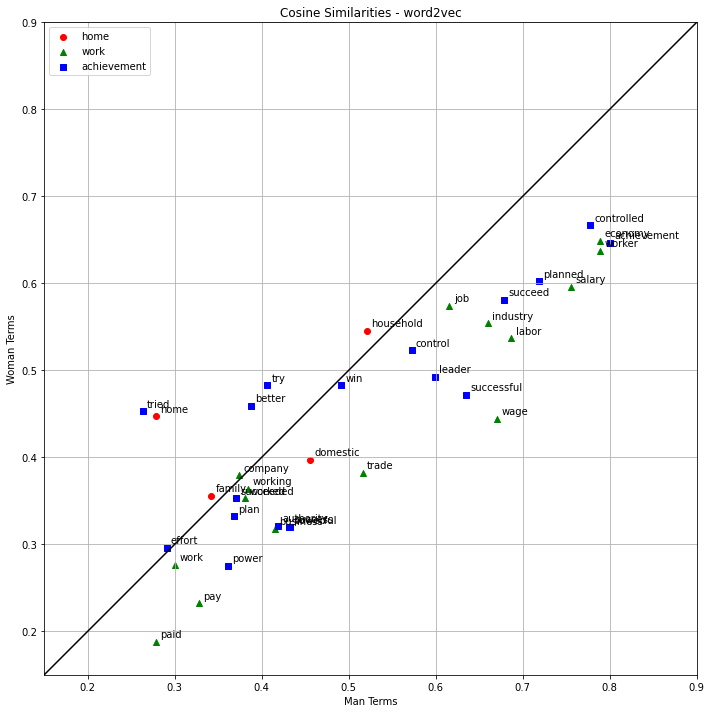

In [38]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)

plt.scatter(simi_home['man'], simi_home['woman'], marker='o', label="home", c='r')
plt.scatter(simi_work['man'], simi_work['woman'], marker='^', label="work", c='g')
plt.scatter(simi_achievement['man'], simi_achievement['woman'], marker='s', label="achievement", c='b')

x = np.linspace(0.15,0.9,100)
plt.plot(x, x, c='black')
plt.legend(loc='best')

plt.title('Cosine Similarities - word2vec')
plt.xlabel('Man Terms')
plt.ylabel('Woman Terms')

plt.xlim([0.15,0.9])
plt.ylim([0.15,0.9])

for i in range(len(simi_table)):
    ax.annotate(simi_table['word'][i], xy=(simi_table['man'][i], simi_table['woman'][i]), 
                xytext=(simi_table['man'][i]+0.005, simi_table['woman'][i]+0.005))

ax.set_aspect('equal', adjustable='box')

plt.savefig("Cosine Similarities - word2vec.png")
plt.grid()
plt.show()